## 1. Read the Frame Perfect Spreadsheet

In [30]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np

url = "https://docs.google.com/spreadsheets/d/1rw1raJLjZ4ZboVbOgFue44GR1hJoU3h6EMuNtXbk0R0/export?format=csv&gid=0"

resp = requests.get(url)
resp.raise_for_status()  # make sure request succeeded

In [31]:
# Read CSV into pandas DataFrame
df = pd.read_csv(StringIO(resp.text), usecols=range(5))

# Use the index of the first NaN in the second column to truncate the DataFrame
nan_index = df.iloc[:, 1].first_valid_index()
nan_mask = df.iloc[:, 1].isna()
if nan_mask.any():
    cut_index = nan_mask.idxmax()  # index of first True
    df = df.iloc[:cut_index]
else:
    df = df.copy()

# Fill NaN with 0
inner_cols = ["60", "120", "240", "Rating"]
df[inner_cols] = df[inner_cols].fillna(0)

# Convert to nested dictionary
fp_values = df.set_index('Level | FPS')[inner_cols].to_dict(orient='index')

print(fp_values)

{'Aeternus': {'60': 212.0, '120': 78.0, '240': 3.0, 'Rating': 380.0}, 'Africa Circles (unnerfed)': {'60': 170.0, '120': 35.0, '240': 0.0, 'Rating': 240.0}, 'CorroZ': {'60': 127.0, '120': 46.0, '240': 0.0, 'Rating': 219.0}, 'Tidal Wave': {'60': 200.0, '120': 1.0, '240': 0.0, 'Rating': 202.0}, 'Amethyst': {'60': 143.0, '120': 13.0, '240': 2.0, 'Rating': 177.0}, 'Ashley Wave Trials': {'60': 155.0, '120': 11.0, '240': 0.0, 'Rating': 177.0}, 'Natural Disaster (unnerfed)': {'60': 120.0, '120': 22.0, '240': 0.0, 'Rating': 164.0}, "Azure Flare (Aeden's)": {'60': 109.0, '120': 23.0, '240': 2.0, 'Rating': 163.0}, 'KOCMOC (old unnerfed)': {'60': 114.0, '120': 19.0, '240': 2.0, 'Rating': 160.0}, 'Thinking Space II': {'60': 108.0, '120': 20.0, '240': 1.0, 'Rating': 152.0}, 'Sarai': {'60': 59.0, '120': 21.0, '240': 10.0, 'Rating': 141.0}, 'Eternal Night (old)': {'60': 107.0, '120': 16.0, '240': 0.0, 'Rating': 139.0}, 'KOCMOC (old nerfed)': {'60': 100.0, '120': 11.0, '240': 0.0, 'Rating': 122.0}, 'Ex

## 2. Read the Pointercrate Demonlist

In [32]:
url = "https://pointercrate.com/demonlist/"
resp = requests.get(url)

html = resp.text   # raw HTML as a string

In [33]:
MAX_NAME_LENGTH = 50
DL_MAX_POS = 50

dl_positions = {}

cur_dl_pos = 1
for i in range(len(html)):
    search_str = f'"#{cur_dl_pos} -'
    if html[i: i+len(search_str)] == search_str:
        demon_name = html[i: i+MAX_NAME_LENGTH].split('"')[1].split(" - ")[1].strip()
        dl_positions[demon_name] = cur_dl_pos
        cur_dl_pos += 1
        if cur_dl_pos > DL_MAX_POS:
            break

print(dl_positions)

{'Thinking Space II': 1, 'Amethyst': 2, 'Tidal Wave': 3, 'Nullscapes': 4, 'BOOBAWAMBA': 5, 'Every End': 6, 'andromeda': 7, 'Silent clubstep': 8, 'Anathema': 9, 'Avernus': 10, 'Acheron': 11, 'Spectre': 12, 'Menace': 13, 'Tunnel of Despair': 14, 'Abyss of Darkness': 15, 'Kyouki': 16, 'Subterminal Point': 17, 'Slaughterhouse': 18, 'KOCMOC': 19, 'Sakupen Circles': 20, 'Deimos': 21, 'Firework': 22, 'The Lightning Rod': 23, 'poocubed': 24, 'KOSETSU': 25, 'Saul Goodman': 26, 'Eyes in the Water': 27, 'MINUSdry': 28, 'Belladonna': 29, 'Operation Evolution': 30, 'Sevvend Clubstep': 31, 'The Hallucination': 32, 'COMBUSTION': 33, 'Deadlier Clubstep': 34, 'Solar Flare': 35, 'Apocalyptic Trilogy': 36, 'LIMBO': 37, 'Gaggatrondra': 38, 'Edge of Destiny': 39, 'Codependence': 40, 'Mayhem': 41, 'walter white': 42, 'Damascus': 43, 'PSYCHOPATH': 44, 'Collapse': 45, 'The Yangire': 46, 'SARYYX NEVER CLEAR': 47, 'ORDINARY': 48, 'The Plunge': 49, 'Midnight': 50}


## 3. Plot each demon’s ranking vs. frame-perfect count

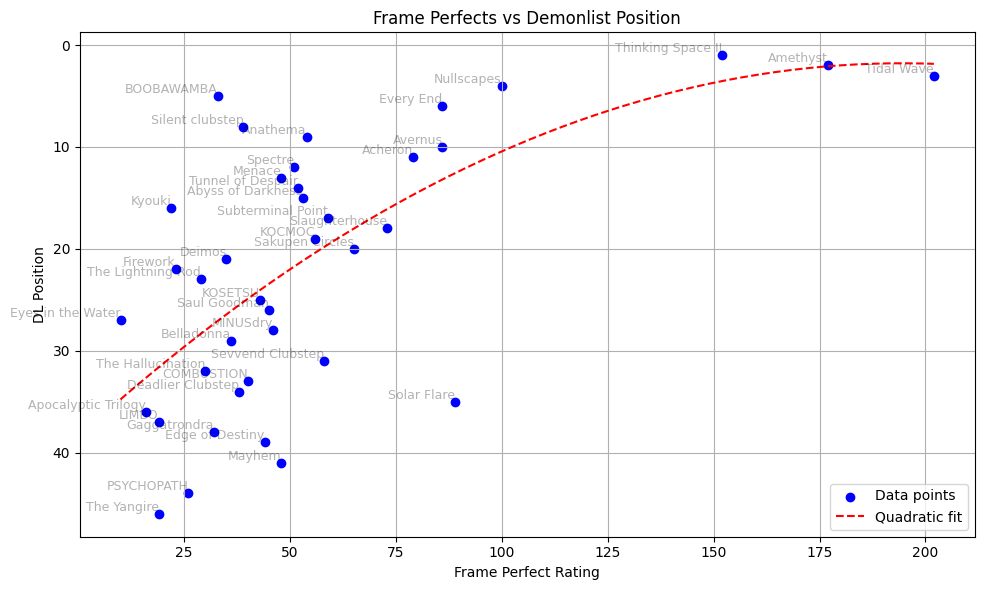

In [34]:
# Define the Frame Perfect metric
METRIC = 'Rating'  # options: '60', '120', '240', 'Rating'

# Filter demons that exist in both dictionaries
common_demons = [demon for demon in dl_positions if demon in fp_values]

# Extract values
frame_perfects = [fp_values[demon][METRIC] for demon in common_demons]
positions = [dl_positions[demon] for demon in common_demons]

# Convert to numpy arrays for fitting
x = np.array(frame_perfects)
y = np.array(positions)

# Fit a quadratic (degree=2) polynomial
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)

# Generate smooth x-values for the curve
x_fit = np.linspace(min(x), max(x), 200)
y_fit = poly(x_fit)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(frame_perfects, positions, color='blue', label='Data points')

# Plot quadratic fit
plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Quadratic fit')

# Annotate each point with the demon name at low opacity
for xi, yi, demon in zip(frame_perfects, positions, common_demons):
    plt.text(xi, yi, demon, fontsize=9, alpha=0.3, ha='right', va='bottom')

plt.title('Frame Perfects vs Demonlist Position')
plt.xlabel(f'{METRIC}FPS Frame Perfects' if METRIC != 'Rating' else 'Frame Perfect Rating')
plt.ylabel('DL Position')
plt.gca().invert_yaxis()  # invert y-axis so higher values are at the bottom
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Predict a new demon's difficulty using the quadratic approximation

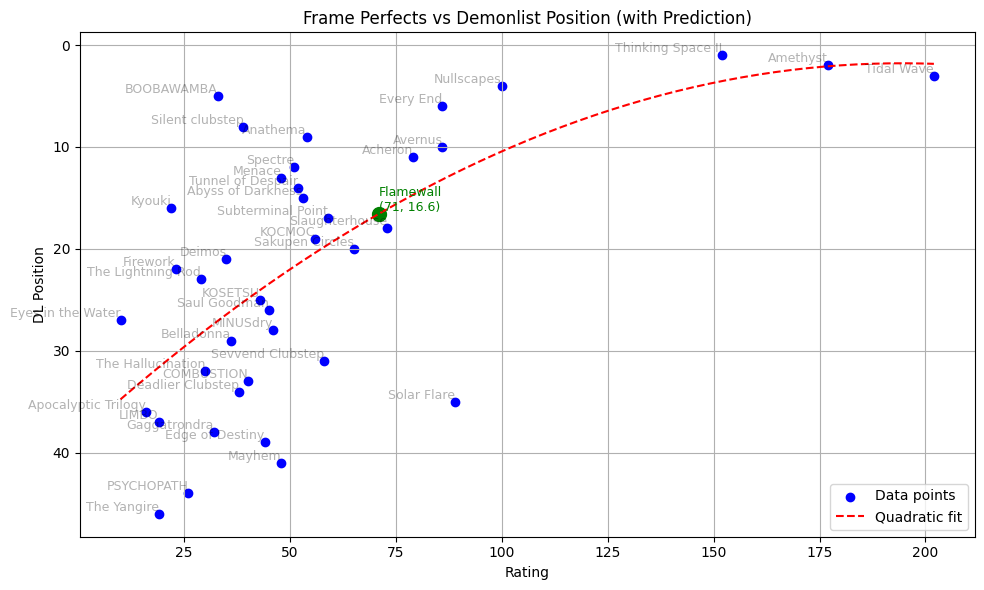

Predicted DL position for Flamewall: 17


In [35]:
# Example: predict a new demon with 180 frame-perfects at 60 FPS
NEW_FP_DEMON = "Flamewall"
NEW_FP_VALUE = 71 

# Predict DL position using the quadratic model
predicted_position = poly(NEW_FP_VALUE)

# Second plot showing the prediction
plt.figure(figsize=(10, 6))
plt.scatter(frame_perfects, positions, color='blue', label='Data points')
plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Quadratic fit')

# Plot the new demon prediction
plt.scatter(NEW_FP_VALUE, predicted_position, color='green', s=100)
plt.text(NEW_FP_VALUE, predicted_position, 
         f"{NEW_FP_DEMON}\n({NEW_FP_VALUE}, {predicted_position:.1f})", 
         fontsize=9, ha='left', va='bottom', color='green')

# Annotate each point with the demon name at low opacity
for xi, yi, demon in zip(frame_perfects, positions, common_demons):
    plt.text(xi, yi, demon, fontsize=9, alpha=0.3, ha='right', va='bottom')

plt.title('Frame Perfects vs Demonlist Position (with Prediction)')
plt.xlabel(f'{METRIC}FPS Frame Perfects' if METRIC != 'Rating' else 'Rating')
plt.ylabel('DL Position')
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Predicted DL position for {NEW_FP_DEMON}: {predicted_position:.0f}")